# 3. Ruas

O que for casa escuro e não for casa, nem prédio claro, nem terra, possivelmente é rua

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from skimage import morphology
import numpy as np
import cv2

from areas_claras_detector import AreasClarasDetector
from areas_vermelhas_detector import AreasVermelhasDetector

from bing_maps import BingMaps

import utils

## 3.1 Imagem base

A imagem base de testes é a imagem do satélite obtida pelo Bing do IFCE - Campus Maracanaú.

Esta imagem é uma boa canditada aos testes por possuir áreas _residenciais_ e _industriais_.

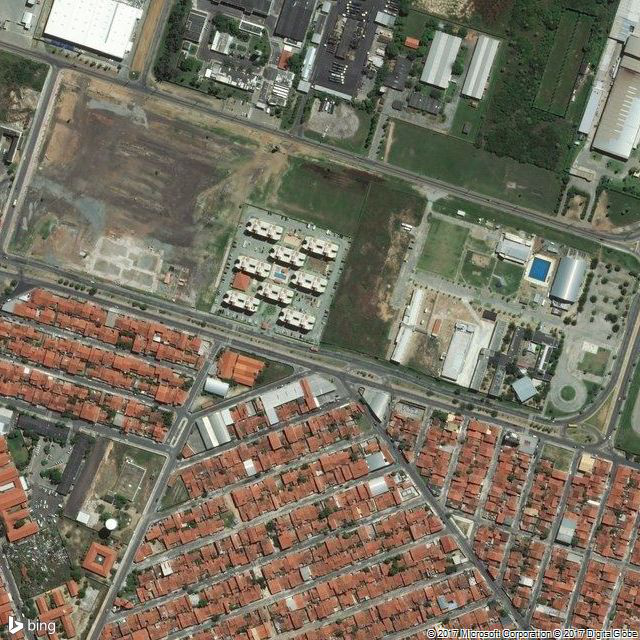

In [2]:
maps = BingMaps('AjhkGze8sCMwACt6rQMCS4ykL0gtBEyb6ku3Fqp78m9TsrrZ9qHHPAf_S8zjJFpR')

image = maps.image(-3.8722232, -38.6133724, 17, width=640, height=640)
image

### 3.2.1 Como funciona

1. Mediana: Uniformizar a imagem (removendo ruidos)
2. Limiarização: Obter cinza - intervalo de cor $([80, 80, 80], [158, 153, 135])$
3. Remover casas
4. Remover terra vermelha
5. Remover prédios luminosos


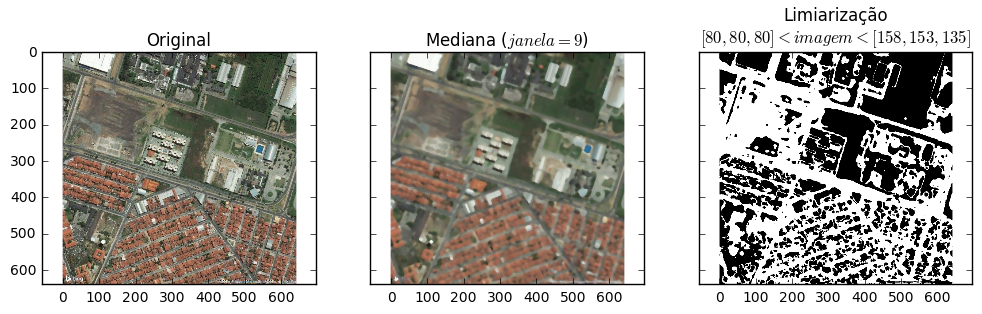

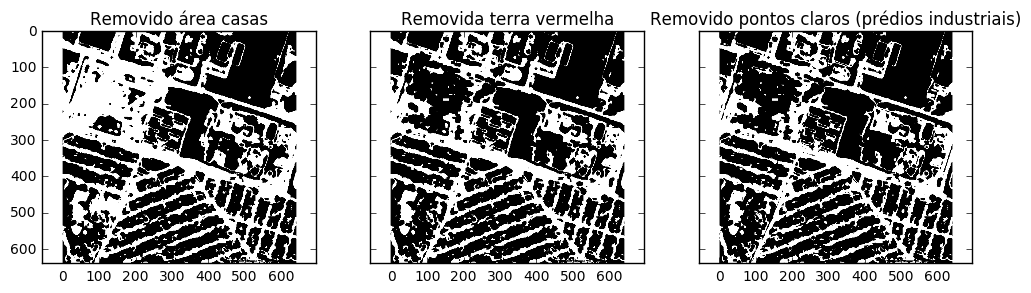

In [3]:
from ruas_detector import RuasDetector

detector = RuasDetector()

limiar_minimo = [80, 80, 80]
limiar_maximo = [158, 153, 135]

imagem_mediana = detector.mediana(np.asarray(image))
imagem_cinza = detector.limiarizar(imagem_mediana, limiar_minimo, limiar_maximo)

detector = AreasVermelhasDetector()
imagem_cinza_sem_casas = imagem_cinza & ~detector.processar_imagem_casa(image)
imagem_cinza_sem_terra_vermelha = imagem_cinza_sem_casas & ~detector.processar_imagem_terra_2(image)

detector = AreasClarasDetector()
imagem_filtrada = imagem_cinza_sem_terra_vermelha & ~detector.processar_imagem(np.asarray(image))
    
grid = utils.ImagemGrid()

grid.show(
    (image, 'Original'),
    (imagem_mediana, 'Mediana ($janela = 9$)'),
    (imagem_cinza, 'Limiarização\n${} < imagem < {}$'.format(limiar_minimo, limiar_maximo)),
    cmap='gray',
)

grid.show(
    (imagem_cinza_sem_casas, 'Removido área casas'),
    (imagem_cinza_sem_terra_vermelha, 'Removida terra vermelha'),
    (imagem_filtrada, 'Removido pontos claros (prédios industriais)'),
    cmap='gray'
)

#casas_e_predios_claros = (house_mask(RMinusG(image)) | mask_abertura)
#image_talvez_ruas_2 = image_talvez_ruas & ~(image_talvez_ruas & casas_e_predios_claros)

### 3.2.2 Resultado

/home/paulo/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


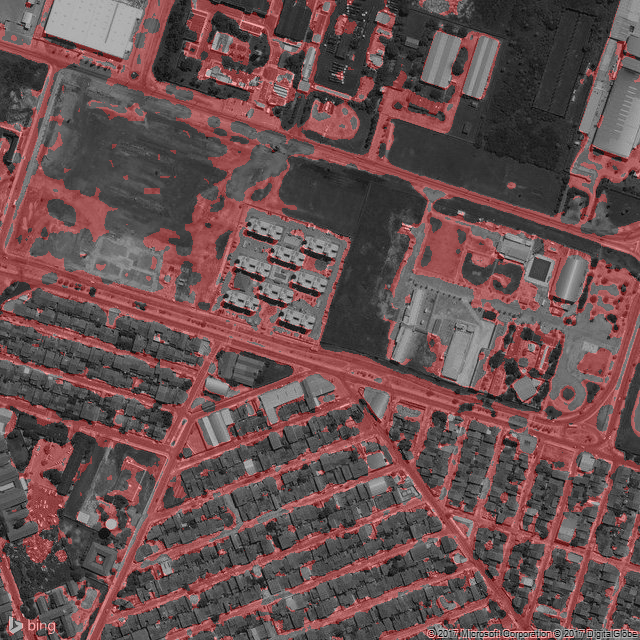

In [4]:
from skimage.color import label2rgb

resultado = label2rgb(
    RuasDetector().processar_imagem(image),
    image=np.asarray(image),
    bg_label=0
)

utils.skshow(resultado)

# Outros testes

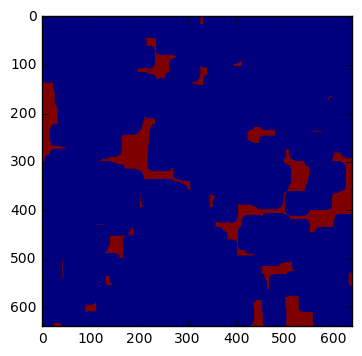

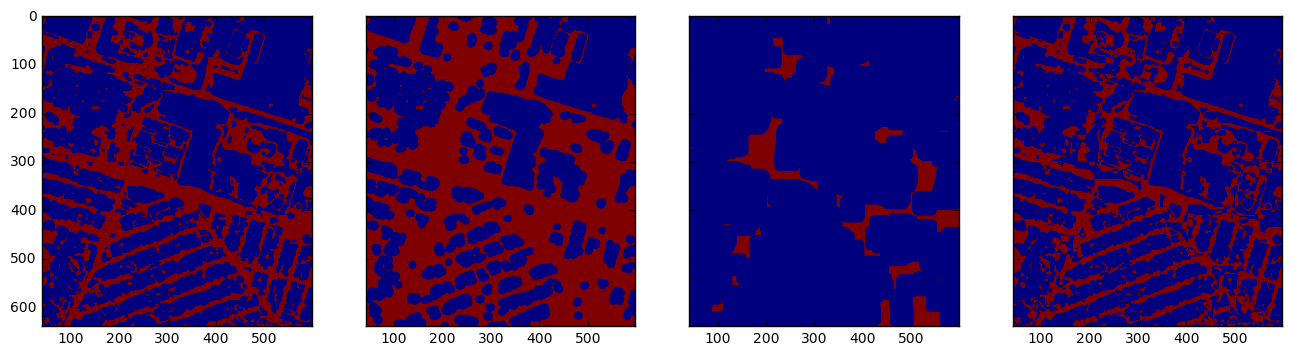

In [5]:
parametro = 8
coisado = morphology.closing(imagem_cinza_sem_terra_vermelha, morphology.disk(parametro))
#plt.imshow(coisado)

coisado_2 = morphology.erosion(coisado, morphology.square(30))
plt.imshow(coisado_2)
#plt.imshow(coisado ^ coisado_2)

grid.show(
    (imagem_cinza_sem_terra_vermelha, ''),
    (coisado, ''),
    (coisado_2, ''),
    (imagem_cinza_sem_terra_vermelha ^ coisado_2, ''),
)

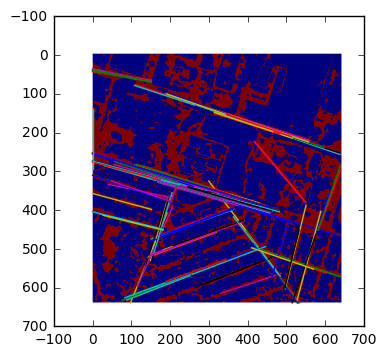

In [6]:
from skimage import transform

lines = transform.probabilistic_hough_line(
    imagem_cinza_sem_terra_vermelha,
    threshold=50,
    line_length=150,
    line_gap=5
)

plt.imshow(imagem_cinza_sem_terra_vermelha)

for line in lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))

plt.show()

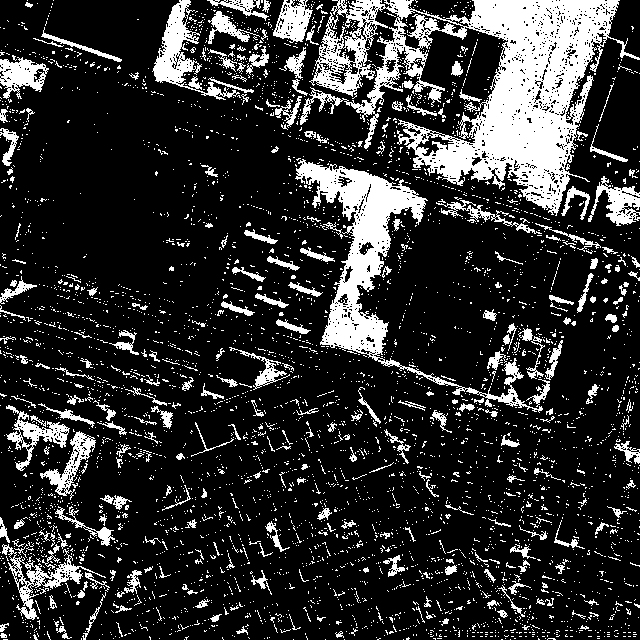

In [7]:
limiar_minimo = np.array([0, 0, 0])
limiar_maximo = np.array([80, 80, 80])
        
utils.skshow(cv2.inRange(np.asarray(image), limiar_minimo, limiar_maximo) == 255)


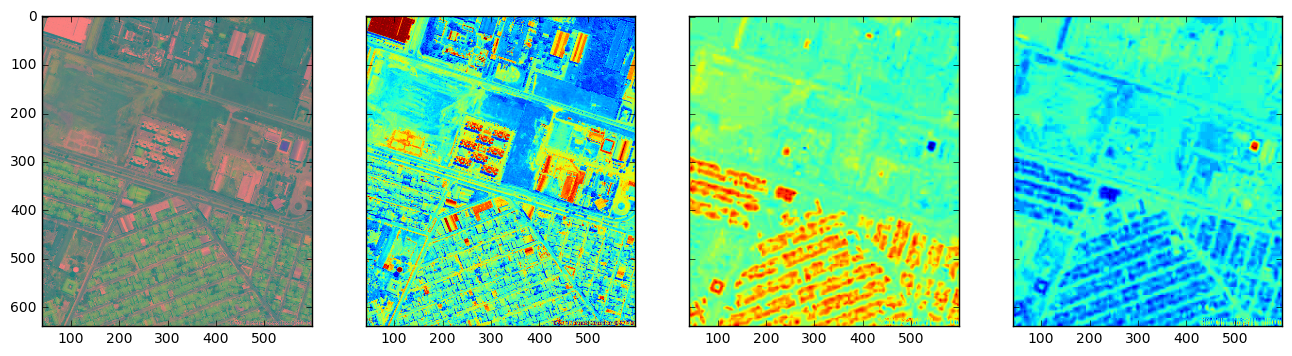

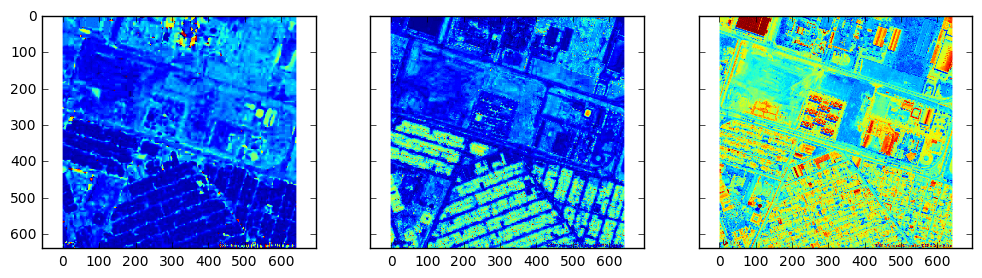

In [30]:
grid = utils.ImagemGrid()

utils.skshow(
    #cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB)[:,:,0]
    cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)[:,:,0]
)

grid.show(
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB), ''),
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB)[:,:,0], ''),
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB)[:,:,1], ''),
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB)[:,:,2], ''),
)

grid.show(
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)[:,:,0], ''),
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)[:,:,1], ''),
    (cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2HSV)[:,:,2], '')
)

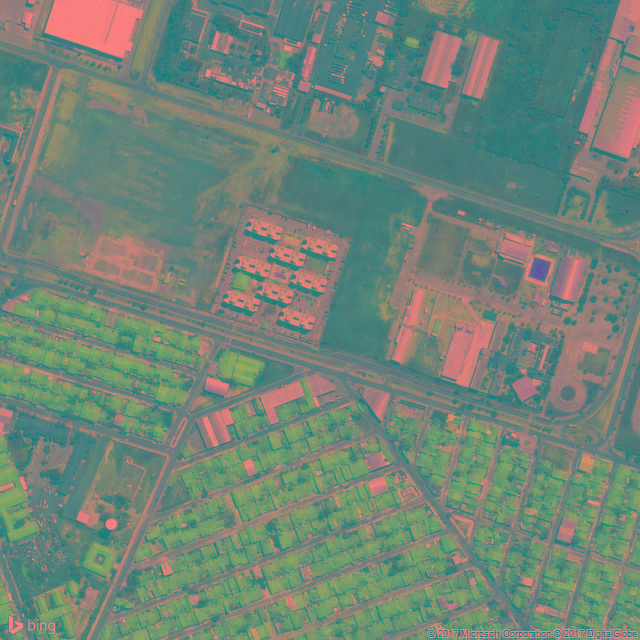

In [32]:
utils.skshow(
    cv2.cvtColor(np.asarray(image), cv2.COLOR_RGB2YCR_CB)
)